**Imports**

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression,Ridge 
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

**[1] Price and size**

In [2]:
price_vs_size = pd.read_csv('/kaggle/input/buenos-aires-real-estate/buenos-aires-real-estate-1.csv')
print("df shape:", price_vs_size.shape)
price_vs_size.head()

df shape: (8606, 16)


,Unnamed: 0,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
1,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,NaN,250000.0,USD,3790600.0,250000.0,117.0,120.0,2136.752137,2083.333333,NaN,4.0,NaN,http://ramos-mejia.properati.com.ar/s7pd_venta...
2,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Cast...,"-34.6497002,-58.658073",410000.0,USD,6216584.0,410000.0,410.0,220.0,1000.000000,1863.636364,NaN,NaN,NaN,http://castelar-moron.properati.com.ar/11vgn_v...
3,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...,"-34.5957086,-58.5669503",180000.0,USD,2729232.0,180000.0,200.0,135.0,900.000000,1333.333333,NaN,5.0,NaN,http://tres-de-febrero.properati.com.ar/7f7u_v...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...


**Retrieving real estate in the capital that cost less than 40,000**

In [3]:
mask=price_vs_size['place_with_parent_names'].str.contains('Capital Federal')
price_vs_size=price_vs_size[mask]
price_vs_size=price_vs_size[price_vs_size['property_type']=='apartment']
price_vs_size=price_vs_size[price_vs_size['price_aprox_usd'].astype(float) <400000]
price_vs_size.shape

(1781, 16)

**Creating a histogram of "surface_covered_in_m2"**

Text(0, 0.5, 'Distribution of Apartment Sizes')

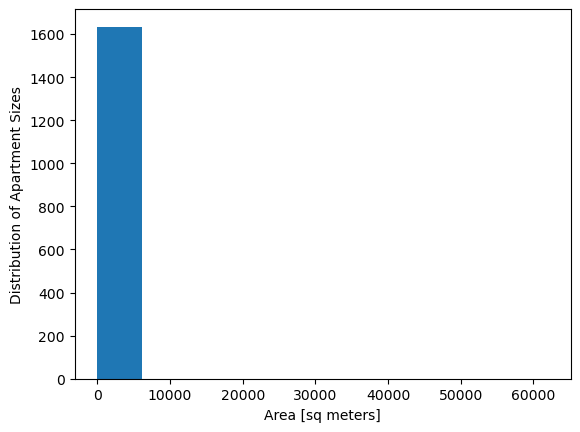

In [4]:
plt.hist(price_vs_size["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Distribution of Apartment Sizes")

**Removing observations that are outliers in the "surface_covered_in_m2" column (all observations should fall between the 0.1 and 0.9 quantiles)**

In [5]:
low,high=price_vs_size["surface_covered_in_m2"].quantile([0.1,0.9])
mask=price_vs_size[price_vs_size["surface_covered_in_m2"].between(low,high)]
price_vs_size=mask
price_vs_size

,Unnamed: 0,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.60,129000.00,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.80,87000.00,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.20,118000.00,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.80,57000.00,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.00,90000.00,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8589,sell,apartment,|Argentina|Capital Federal|Barracas|,"-34.631591,-58.370191",1118100.0,ARS,1114996.65,73536.95,49.0,42.0,1500.754082,26621.428570,3.0,1.0,NaN,http://barracas.properati.com.ar/npf1_venta_de...
8590,sell,apartment,|Argentina|Capital Federal|Almagro|,"-34.6045547,-58.4182063",119000.0,USD,1804325.60,119000.00,46.0,41.0,2586.956522,2902.439024,NaN,NaN,NaN,http://almagro.properati.com.ar/ea4d_venta_dep...
8593,sell,apartment,|Argentina|Capital Federal|Barracas|,"-34.6240024,-58.3905883",62000.0,USD,940068.80,62000.00,NaN,43.0,NaN,1441.860465,NaN,2.0,NaN,http://barracas.properati.com.ar/oc61_venta_de...
8601,sell,apartment,|Argentina|Capital Federal|San Nicolás|,"-34.601455,-58.378132",125000.0,USD,1895300.00,125000.00,NaN,70.0,NaN,1785.714286,2.0,3.0,NaN,http://san-nicolas.properati.com.ar/1004t_vent...


**A scatter plot that shows price ("price_aprox_usd") vs area ("surface_covered_in_m2")**

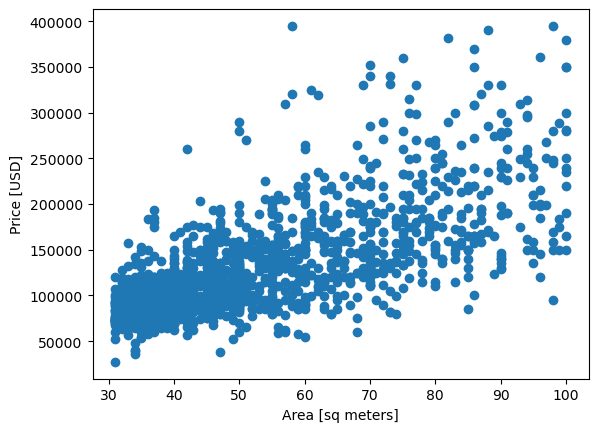

In [6]:
plt.scatter(x=price_vs_size["surface_covered_in_m2"],y=price_vs_size["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.show()

**Creating a feature matrix that correspons to feature value "area covered in m2"**

In [7]:
features = ["surface_covered_in_m2"]
X_train = price_vs_size[features]
X_train

,surface_covered_in_m2
4,70.0
9,42.0
29,54.0
40,42.0
41,50.0
...,...
8589,42.0
8590,41.0
8593,43.0
8601,70.0


**Creating target vector that corresponds to "price_aprox_usd"**

In [8]:
target = "price_aprox_usd"
y_train = price_vs_size[target]
y_train.shape

(1343,)

**Baseline**

In [9]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
y_pred_baseline[0]

135527.83871928515

**Relationship between "X_train" and baseline**

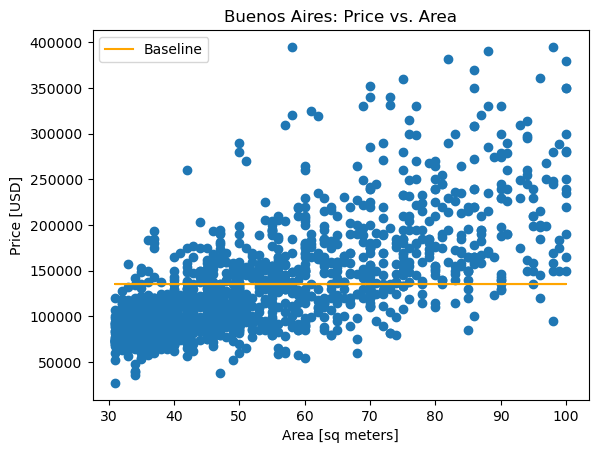

In [10]:
plt.plot(X_train["surface_covered_in_m2"],y_pred_baseline,color="orange",label="Baseline")
plt.scatter(X_train["surface_covered_in_m2"], y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();
plt.show()

**Baseline mean absolute error**

In [11]:
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)
mae_baseline

45199.45795261716

**Creating and trainning a LinearRegression model**

In [12]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)
mae_training 

31248.2561380616

In [13]:
X_test = pd.read_csv("/kaggle/input/features/buenos-aires-real-estate-features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    117330.058901
1    135355.037823
2     88039.468152
3     88039.468152
4    106064.447074
dtype: float64

**Extracting intercept and coefficient from the model**

In [14]:
intercept = model.intercept_
intercept 

11433.307732797926

In [15]:
coefficient = model.coef_[0]
coefficient

2253.1223652775843

In [16]:
print(f"Apartment Price= {intercept} + {coefficient} * surface")

Apartment Price= 11433.307732797926 + 2253.1223652775843 * surface


**Relationship between the observations in X_train and y_pred_training**

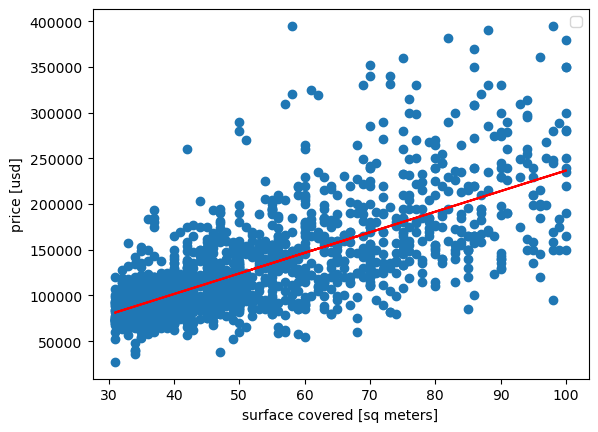

In [17]:
plt.plot(X_train["surface_covered_in_m2"], model.predict(X_train), color='red')
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();

**[2] Price and location**

In [18]:
price_vs_location = price_vs_size
price_vs_location

,Unnamed: 0,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.60,129000.00,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.80,87000.00,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.20,118000.00,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.80,57000.00,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.00,90000.00,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8589,sell,apartment,|Argentina|Capital Federal|Barracas|,"-34.631591,-58.370191",1118100.0,ARS,1114996.65,73536.95,49.0,42.0,1500.754082,26621.428570,3.0,1.0,NaN,http://barracas.properati.com.ar/npf1_venta_de...
8590,sell,apartment,|Argentina|Capital Federal|Almagro|,"-34.6045547,-58.4182063",119000.0,USD,1804325.60,119000.00,46.0,41.0,2586.956522,2902.439024,NaN,NaN,NaN,http://almagro.properati.com.ar/ea4d_venta_dep...
8593,sell,apartment,|Argentina|Capital Federal|Barracas|,"-34.6240024,-58.3905883",62000.0,USD,940068.80,62000.00,NaN,43.0,NaN,1441.860465,NaN,2.0,NaN,http://barracas.properati.com.ar/oc61_venta_de...
8601,sell,apartment,|Argentina|Capital Federal|San Nicolás|,"-34.601455,-58.378132",125000.0,USD,1895300.00,125000.00,NaN,70.0,NaN,1785.714286,2.0,3.0,NaN,http://san-nicolas.properati.com.ar/1004t_vent...


In [19]:
price_vs_location[["lat", "lon"]]=price_vs_location["lat-lon"].str.split(",",expand=True).astype(float)
price_vs_location.drop("lat-lon",axis=1, inplace=True)
price_vs_location

,Unnamed: 0,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.60,129000.00,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.80,87000.00,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
29,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.20,118000.00,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
40,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.80,57000.00,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
41,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.00,90000.00,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8589,sell,apartment,|Argentina|Capital Federal|Barracas|,1118100.0,ARS,1114996.65,73536.95,49.0,42.0,1500.754082,26621.428570,3.0,1.0,NaN,http://barracas.properati.com.ar/npf1_venta_de...,-34.631591,-58.370191
8590,sell,apartment,|Argentina|Capital Federal|Almagro|,119000.0,USD,1804325.60,119000.00,46.0,41.0,2586.956522,2902.439024,NaN,NaN,NaN,http://almagro.properati.com.ar/ea4d_venta_dep...,-34.604555,-58.418206
8593,sell,apartment,|Argentina|Capital Federal|Barracas|,62000.0,USD,940068.80,62000.00,NaN,43.0,NaN,1441.860465,NaN,2.0,NaN,http://barracas.properati.com.ar/oc61_venta_de...,-34.624002,-58.390588
8601,sell,apartment,|Argentina|Capital Federal|San Nicolás|,125000.0,USD,1895300.00,125000.00,NaN,70.0,NaN,1785.714286,2.0,3.0,NaN,http://san-nicolas.properati.com.ar/1004t_vent...,-34.601455,-58.378132


**Adding another dataframe**

In [20]:
df = pd.read_csv("/kaggle/input/buenos-aires-real-estate/buenos-aires-real-estate-2.csv")

In [21]:
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    df[["lat", "lon"]]=df["lat-lon"].str.split(",",expand=True).astype(float)
    df.drop("lat-lon",axis=1, inplace=True)
    

In [22]:
price_vs_location = pd.concat([price_vs_location, df], ignore_index=True)
price_vs_location.head()

,Unnamed: 0,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,operation
0,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,NaN
1,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,NaN
2,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,NaN
3,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,NaN
4,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,NaN


**Mapbox scatter plot that shows the location of the apartments**

In [23]:
fig = px.scatter_mapbox(
    price_vs_location, 
    lat="lat",
    lon="lon",
    width=600,  
    height=600, 
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"], 
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

**3D scatter plot**

In [24]:
fig = px.scatter_3d(
    price_vs_location,
    x="lon",
    y="lat",
    z="price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

fig.show()

**Building the model**

In [25]:
features = ["lon", "lat"]
X_train = price_vs_location[features]
X_train.head

<bound method NDFrame.head of             lon        lat
0    -58.454693 -34.584651
1    -58.500115 -34.638979
2    -58.459957 -34.615847
3    -58.382382 -34.625222
4    -58.412511 -34.610610
...         ...        ...
2653 -58.440472 -34.626138
2654 -58.415568 -34.590708
2655 -58.470731 -34.537851
2656 -58.444045 -34.596715
2657 -58.455439 -34.574537

[2658 rows x 2 columns]>

In [26]:
target = "price_aprox_usd"
y_train = price_vs_location[target]

**Baseline**

In [27]:
y_mean = y_train.mean()
y_pred_baseline =[y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)
mae_baseline

45422.75166805662

In [28]:
model = make_pipeline(
SimpleImputer(), 
LinearRegression())
model.fit(X_train,y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [29]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
mae_training 

42962.72485842019

**This suggests that latitude and longitude aren't as strong predictors of price as size is**

**[3] Price and neighborhood**

In [30]:
files= glob("/kaggle/input/buenos-aires-real-estate/buenos-aires-real-estate-*.csv")

**Im too lazy to put them in a function lol**

In [31]:
li = []
for file in files :
    df = pd.read_csv(file)
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    li.append(df)
    

In [32]:
price_vs_neighborhood = pd.concat(li, ignore_index=True)
price_vs_neighborhood.head()

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,Unnamed: 0
0,sell,apartment,|Argentina|Capital Federal|Recoleta|,215000.0,USD,3259916.00,215000.00,40.0,35.0,5375.000000,6142.857143,NaN,1.0,3500.0,http://recoleta.properati.com.ar/12j4v_venta_d...,-34.588993,-58.400133,NaN
1,sell,apartment,|Argentina|Capital Federal|Recoleta|,341550.0,USD,5178717.72,341550.00,NaN,90.0,NaN,3795.000000,8.0,2.0,NaN,http://recoleta.properati.com.ar/100t0_venta_d...,-34.588044,-58.398066,NaN
2,sell,apartment,|Argentina|Capital Federal|Monserrat|,1386000.0,ARS,1382153.13,91156.62,39.0,33.0,2337.349231,42000.000000,NaN,NaN,NaN,http://monserrat.properati.com.ar/t05l_venta_d...,-34.623320,-58.397461,NaN
3,sell,apartment,|Argentina|Capital Federal|Belgrano|,105000.0,USD,1592052.00,105000.00,NaN,33.0,NaN,3181.818182,1.0,1.0,NaN,http://belgrano.properati.com.ar/zsd5_venta_de...,-34.553897,-58.451939,NaN
4,sell,apartment,|Argentina|Capital Federal|Villa del Parque|,89681.0,USD,1359779.19,89681.00,46.0,39.0,1949.586957,2299.512821,NaN,1.0,1500.0,http://villa-del-parque.properati.com.ar/12q2f...,-34.628813,-58.472230,NaN


In [33]:
price_vs_neighborhood["neighborhood"]=price_vs_neighborhood["place_with_parent_names"].str.split("|", expand=True)[3]
price_vs_neighborhood.drop("place_with_parent_names", axis=1, inplace= True)
price_vs_neighborhood

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,Unnamed: 0,neighborhood
0,sell,apartment,215000.0,USD,3259916.00,215000.00,40.0,35.0,5375.000000,6142.857143,NaN,1.0,3500.0,http://recoleta.properati.com.ar/12j4v_venta_d...,-34.588993,-58.400133,NaN,Recoleta
1,sell,apartment,341550.0,USD,5178717.72,341550.00,NaN,90.0,NaN,3795.000000,8.0,2.0,NaN,http://recoleta.properati.com.ar/100t0_venta_d...,-34.588044,-58.398066,NaN,Recoleta
2,sell,apartment,1386000.0,ARS,1382153.13,91156.62,39.0,33.0,2337.349231,42000.000000,NaN,NaN,NaN,http://monserrat.properati.com.ar/t05l_venta_d...,-34.623320,-58.397461,NaN,Monserrat
3,sell,apartment,105000.0,USD,1592052.00,105000.00,NaN,33.0,NaN,3181.818182,1.0,1.0,NaN,http://belgrano.properati.com.ar/zsd5_venta_de...,-34.553897,-58.451939,NaN,Belgrano
4,sell,apartment,89681.0,USD,1359779.19,89681.00,46.0,39.0,1949.586957,2299.512821,NaN,1.0,1500.0,http://villa-del-parque.properati.com.ar/12q2f...,-34.628813,-58.472230,NaN,Villa del Parque
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6577,sell,apartment,227000.0,USD,3441864.80,227000.00,126.0,84.0,1801.587302,2702.380952,NaN,4.0,3200.0,http://villa-general-mitre.properati.com.ar/vi...,-34.614835,-58.466307,NaN,Villa General Mitre
6578,sell,apartment,85267.0,USD,1292852.36,85267.00,40.0,38.0,2131.675000,2243.868421,NaN,1.0,NaN,http://san-telmo.properati.com.ar/vayv_venta_d...,-34.623335,-58.374838,NaN,San Telmo
6579,sell,apartment,1200000.0,ARS,1196669.37,78923.48,NaN,50.0,NaN,24000.000000,NaN,2.0,NaN,http://barracas.properati.com.ar/11bzh_venta_d...,-34.631213,-58.371545,NaN,Barracas
6580,sell,apartment,240000.0,USD,3638976.00,240000.00,55.0,44.0,4363.636364,5454.545455,NaN,2.0,NaN,http://palermo.properati.com.ar/ounv_venta_dep...,-34.562500,-58.458333,NaN,Palermo


**Modeling**

In [34]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train =price_vs_neighborhood[target]
X_train = price_vs_neighborhood[features]

In [35]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

**Encoding categorial data**

In [36]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Recoleta,neighborhood_Monserrat,neighborhood_Belgrano,neighborhood_Villa del Parque,neighborhood_Villa Pueyrredón,neighborhood_Almagro,neighborhood_Palermo,neighborhood_,neighborhood_Tribunales,neighborhood_Balvanera,...,neighborhood_Velez Sarsfield,neighborhood_Monte Castro,neighborhood_Las Cañitas,neighborhood_Constitución,neighborhood_Parque Avellaneda,neighborhood_Villa Soldati,neighborhood_Versalles,neighborhood_Pompeya,neighborhood_Villa Real,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
model = make_pipeline(OneHotEncoder(use_cat_names=True), Ridge())
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [42]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
mae_training

39350.21591281253

In [43]:
X_test = pd.read_csv("/kaggle/input/features/buenos-aires-real-estate-features.csv")[features]
y_pred_test = pd.Series(model2.predict(X_test))
y_pred_test.head()

0    246624.694624
1    161355.968734
2     98232.051308
3    110846.030377
4    127777.538197
dtype: float64

In [44]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
feature_names = model.named_steps["onehotencoder"].get_feature_names_out()
feat_imp = pd.Series(coefficients, index= feature_names)
feat_imp.head()

neighborhood_Recoleta            72740.780756
neighborhood_Monserrat          -20292.596013
neighborhood_Belgrano            46954.208009
neighborhood_Villa del Parque   -12595.500847
neighborhood_Villa Pueyrredón    -8093.450148
dtype: float64

In [46]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (72740.78 * neighborhood_Recoleta)
+ (-20292.6 * neighborhood_Monserrat)
+ (46954.21 * neighborhood_Belgrano)
+ (-12595.5 * neighborhood_Villa del Parque)
+ (-8093.45 * neighborhood_Villa Pueyrredón)
+ (2903.34 * neighborhood_Almagro)
+ (45934.41 * neighborhood_Palermo)
+ (-19370.74 * neighborhood_)
+ (-7818.09 * neighborhood_Tribunales)
+ (-11172.55 * neighborhood_Balvanera)
+ (55590.93 * neighborhood_Barrio Norte)
+ (-3230.37 * neighborhood_Once)
+ (5638.47 * neighborhood_San Telmo)
+ (-48669.35 * neighborhood_Villa Lugano)
+ (12223.11 * neighborhood_Coghlan)
+ (-4618.66 * neighborhood_Barracas)
+ (12671.71 * neighborhood_Villa Urquiza)
+ (4330.55 * neighborhood_Abasto)
+ (6277.05 * neighborhood_Villa Crespo)
+ (-19843.92 * neighborhood_Villa Santa Rita)
+ (38436.33 * neighborhood_Colegiales)
+ (-7108.23 * neighborhood_Paternal)
+ (9252.89 * neighborhood_Caballito)
+ (-7678.62 * neighborhood_Parque Chacabuco)
+ (27042.61 * neighborhood_Retiro)
+ (3860.58 * neighbo

**A horizontal bar chart that shows the top 20 coefficients**

<function matplotlib.pyplot.show(close=None, block=None)>

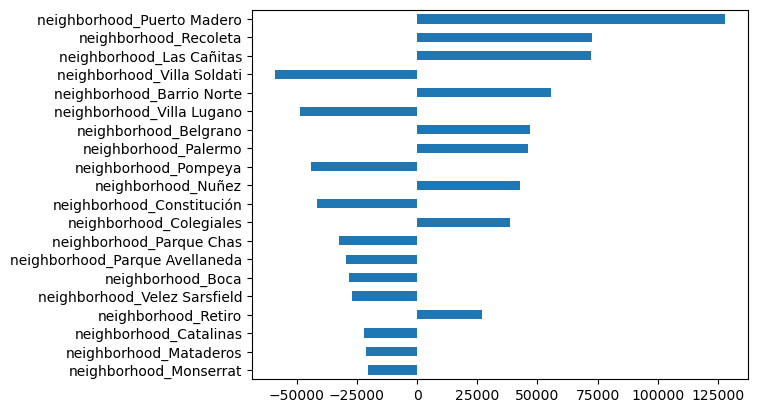

In [48]:
feat_imp.sort_values(key=abs).tail(20).plot(kind="barh")
plt.show

**[4] Predicting price with size, location, and neighborhood**

In [49]:
price_and_everything=price_vs_neighborhood

In [51]:
price_and_everything.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   5239 non-null   object 
 1   property_type               6582 non-null   object 
 2   price                       6582 non-null   float64
 3   currency                    6582 non-null   object 
 4   price_aprox_local_currency  6582 non-null   float64
 5   price_aprox_usd             6582 non-null   float64
 6   surface_total_in_m2         4752 non-null   float64
 7   surface_covered_in_m2       6582 non-null   float64
 8   price_usd_per_m2            4536 non-null   float64
 9   price_per_m2                6582 non-null   float64
 10  rooms                       5286 non-null   float64
 11  properati_url               6582 non-null   object 
 12  lat                         6316 non-null   float64
 13  lon                         6316 

In [50]:
price_and_everything.drop(columns=["floor","expenses"], inplace=True)

In [52]:
price_and_everything.select_dtypes("object").nunique()
price_and_everything.drop(columns=["operation","property_type","currency","properati_url"], axis=1, inplace=True)

In [54]:
sorted(price_and_everything.columns)

['Unnamed: 0',
 'lat',
 'lon',
 'neighborhood',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

In [59]:
price_and_everything.drop(columns=['price',
 'Unnamed: 0',
 'price_aprox_local_currency',
 'price_per_m2',
 'price_usd_per_m2'], inplace=True)

<AxesSubplot:>

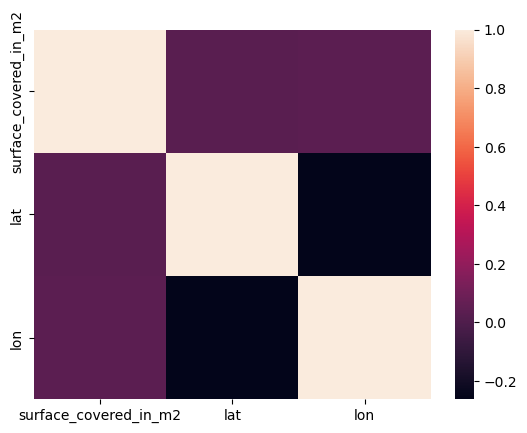

In [65]:
corr=price_and_everything.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr)

**Modeling**

In [66]:
target = "price_aprox_usd"
X_train= price_and_everything.iloc[:,1:]
y_train= price_and_everything[target]
X_train

,surface_covered_in_m2,lat,lon,neighborhood
0,35.0,-34.588993,-58.400133,Recoleta
1,90.0,-34.588044,-58.398066,Recoleta
2,33.0,-34.623320,-58.397461,Monserrat
3,33.0,-34.553897,-58.451939,Belgrano
4,39.0,-34.628813,-58.472230,Villa del Parque
...,...,...,...,...
6577,84.0,-34.614835,-58.466307,Villa General Mitre
6578,38.0,-34.623335,-58.374838,San Telmo
6579,50.0,-34.631213,-58.371545,Barracas
6580,44.0,-34.562500,-58.458333,Palermo


In [68]:
y_mean= y_train.mean()
y_pred_baseline=[y_mean]* len(y_train)
y_pred_baseline[0]

132383.83701458524

In [69]:
mean_absolute_error(y_train, y_pred_baseline)

44860.10834274133

In [70]:
model =make_pipeline(OneHotEncoder(use_cat_names=True),SimpleImputer(), Ridge() )
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [71]:
X_test = pd.read_csv("/kaggle/input/features/buenos-aires-real-estate-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

**A function that takes four arguments (area, lat, lon, and neighborhood) and returns the prediction for apartment price.**

In [72]:
def make_prediction(area, lat, lon, neighborhood):
    data ={
        "surface_covered_in_m2": area,
        "lat":lat,
        "lon":lon,
        "neighborhood" :neighborhood}
    df= pd.DataFrame(data, index=[0])
    prediction = model.predict(df)
    return f"Predicted apartment price: ${prediction}"

In [73]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $[250775.11270376]'

In [74]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…